In [539]:
import numpy as np
import pandas as pd
import cv2
import matplotlib.pyplot as plt
%matplotlib inline
import os
import re
import time
import copy
from random import sample
from PIL import Image
from skimage import io, transform
import json
import csv
import torch
from torch.utils.data import Dataset, DataLoader
from torchvision import transforms, utils, models
import torch.nn as nn
import torch.optim as optim
from torch.optim import lr_scheduler
import torch.backends.cudnn as cudnn

In [540]:
def plotBBox(image, label):
    
    coords = label
    im_h, im_w = image.shape[:2]
    for i in range(len(label)):
        center = tuple(map(int, (im_w * coords[i, 2], im_h * coords[i, 3])))
        low_left = tuple(map(int, (im_w * (coords[i, 2] - coords[i, 4]/2),
                                   im_h * (coords[i, 3] - coords[i, 5]/2))))
        up_right = tuple(map(int, (im_w * (coords[i, 2] + coords[i, 4]/2), 
                                 im_h * (coords[i, 3] + coords[i, 5]/2))))

        #color = (i * 100 % 255, i * 75 % 255, i * 50 % 255)
        color = (255,255,0)
        image = cv2.circle(image, center, radius = 2, color = color, thickness = 5)
        image = cv2.rectangle(image, low_left, up_right, color = color, thickness = 5)
        
    #fig, ax = plt.subplots(figsize=(10, 7))
    #ax.imshow(cv2.cvtColor(image, cv2.COLOR_BGR2RGB))
    
    return cv2.cvtColor(image, cv2.COLOR_BGR2RGB)

In [600]:
path_root = "/usr/users/vogg/Labelling/Lemurs/Individual_imgs/" #the folder where the images are
path_labels = os.path.join(path_root, "labels_with_ids/")
path_train = os.path.join(path_root, "images/")
path_val = os.path.join(path_root, "eval/")

In [601]:
[file for file in os.listdir(path1) if not file.startswith(".")][:4]

['0_GX010099_small_20825.txt',
 '0_GX010029_small_6944.txt',
 '0_GX010125_small_12542.txt',
 'GX010030 2_small_5124.txt']

In [602]:
class LemurIDDataset(Dataset):
    
    def __init__(self, image_path, label_path, transforms=None):
        """
        Args:
            csv_file (string): Path to the csv file with annotations.
            root_dir (string): Directory with all the images.
            transform (callable, optional): Optional transform to be applied
                on a sample.
        """
        self.image_path = image_path
        self.label_path = label_path
        self.file_list = [file for file in os.listdir(self.image_path) if not file.startswith(".")]
        keep_list = []
        for file in self.file_list:
            file2 = file.replace(".jpg",".txt")
            label_file = os.path.join(self.label_path, file2)
            label = pd.read_csv(label_file, header = None, sep = " ").to_numpy()
            if label[0,4] * label[0,5] > 0.025:
                keep_list.append(file)
        self.file_list = [file for file in self.file_list if file in keep_list]
        
        self.transform = transforms
        self.classes = ['Cha', 'Flo', 'Gen', 'Geo', 'Her', 'Rab', 'Red'] # in the future: add Uns (=Unsure) class for lemurs whose identity is not visible

    def __len__(self):
        return len(self.file_list)

    def __getitem__(self, idx):
        if torch.is_tensor(idx):
            idx = idx.tolist()

        img_file = os.path.join(self.image_path,
                                self.file_list[idx])
        label_file = os.path.join(self.label_path,
                                self.file_list[idx].replace(".jpg",".txt"))
        
        image = cv2.imread(img_file)
        
        label = pd.read_csv(label_file, header = None, sep = " ").to_numpy()
        sample = {'image': image, 'label': label}

        if self.transform:
            sample = self.transform(sample)

        return sample

In [642]:
val_dataset = LemurIDDataset(image_path = path_val, label_path = path_labels)
train_dataset = LemurIDDataset(image_path = path_train, label_path = path_labels)

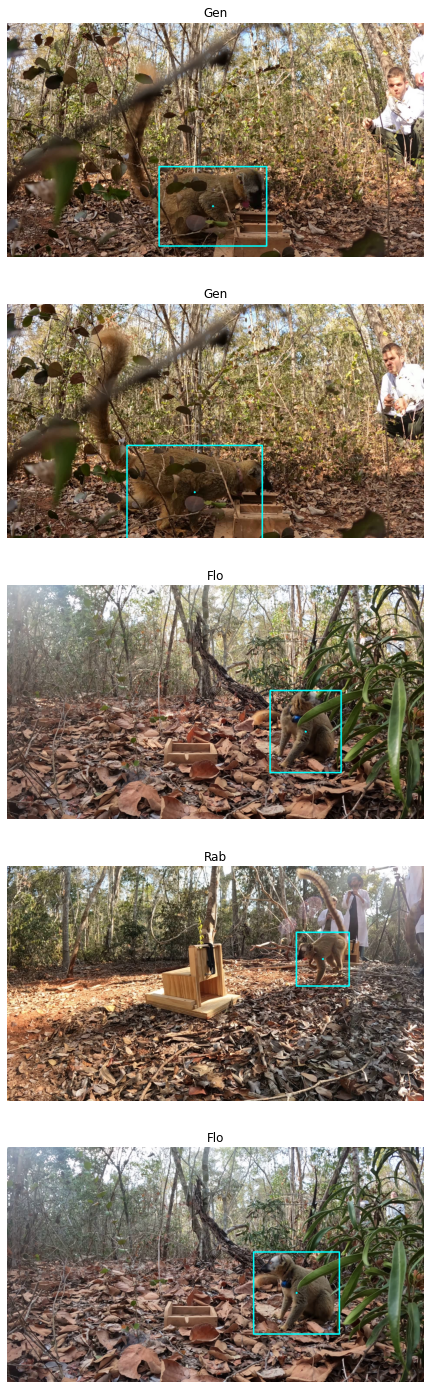

In [643]:
n = 5
fig, axs = plt.subplots(n,1, figsize=(15,n*5))
indivs = ['Cha', 'Flo', 'Gen', 'Geo', 'Her', 'Rab', 'Red']
for i in range(len(val_dataset)):
    sample = val_dataset[i]

    #ax = plt.subplot(1, 3, i + 1)
    axs[i].set_title('{}'.format(indivs[int(sample['label'][0][6])]))
    axs[i].axis('off')
    axs[i].imshow(plotBBox(**sample))

    if i == (n-1):
        plt.show()
        break

In [644]:
class Rescale(object):
    """Rescale the image in a sample to a given size.

    Args:
        output_size (tuple or int): Desired output size. If tuple, output is
            matched to output_size.
    """

    def __init__(self, output_size):
        assert isinstance(output_size, (int, tuple))
        self.output_size = output_size

    def __call__(self, sample):
        image, label = sample['image'], sample['label']

        h, w = image.shape[:2]
        
        new_h = int(self.output_size)
        new_w = int(self.output_size)
        img = cv2.resize(image, (new_h, new_w))

        # h and w are swapped for label because for images,
        # x and y axes are axis 1 and 0 respectively

        return {'image': img, 'label': np.array(label)}


class CropToBBox(object):
    """Crop randomly the image in a sample.

    Args:
        output_size (tuple or int): Desired output size. If int, square crop
            is made.
    """

    def __call__(self, sample):
        image, label = sample['image'], sample['label']
        
        

        h, w = image.shape[:2]

        im_h, im_w = image.shape[:2]
        image = image[max(0, int(im_h * (label[0][3] - label[0][5] / 2))): int(im_h * (label[0][3] + label[0][5] / 2)),
                      max(0, int(im_w * (label[0][2] - label[0][4] / 2))): int(im_w * (label[0][2] + label[0][4] / 2))]

        label[0][2] = 0.5
        label[0][3] = 0.5
        label[0][4] = 1
        label[0][5] = 1
        
        return {'image': image, 'label': np.array(label)}
    
class RandomHorizontalFlip(object):
    """
    Args:
        p (float): probability of the image being flipped. Default value is 0.5
    """

    def __init__(self, p):
        self.p = p
    
    def __call__(self, sample):
        image, label = sample['image'], sample['label']
        
        if torch.rand(1) < self.p:
            return {'image': cv2.flip(image, 1), 'label': np.array(label)}
        return {'image': image, 'label': np.array(label)}


class ToTensor(object):
    """Convert ndarrays in sample to Tensors."""

    def __call__(self, sample):
        image, label = sample['image'], sample['label']

        # swap color axis because
        # numpy image: H x W x C
        # torch image: C x H x W
        image = image.transpose((2, 0, 1))
        return {'image': torch.from_numpy(image),
                'label': torch.from_numpy(label)}

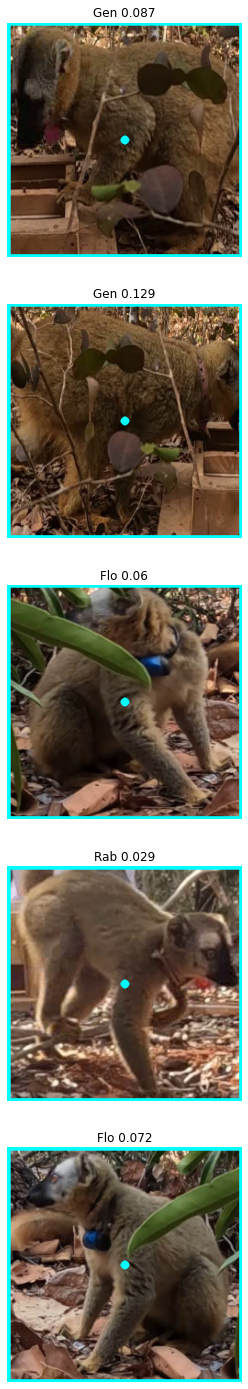

In [646]:
## Output shows label and size of the bbox in original image (used for filtering small bounding boxes in Dataset)

n = 5
fig, axs = plt.subplots(n,1, figsize=(15,n*5))
indivs = ['Cha', 'Flo', 'Gen', 'Geo', 'Her', 'Rab', 'Red']
for i in range(len(val_dataset)):
    sample = val_dataset[i]
    area = sample['label']
    #ax = plt.subplot(1, 3, i + 1)
    axs[i].set_title(f'{format(indivs[int(area[0,6])])} {np.round(area[0,4] * area[0,5], 3)}')
    axs[i].axis('off')
    combined = transforms.Compose([CropToBBox(), Rescale(256), RandomHorizontalFlip(0.5)])
    transformed_sample = combined(sample)
    
    
    axs[i].imshow(plotBBox(**transformed_sample))

    if i == (n-1):
        plt.show()
        break

In [651]:
lemur_dataset = LemurIDDataset(image_path = path2, label_path = path1, transforms = transforms.Compose([CropToBBox(), Rescale(256),  ToTensor()]))
dataloader = DataLoader(lemur_dataset, batch_size = 4, 
                        shuffle = True, num_workers = 0)

transform_list = transforms.Compose([CropToBBox(), 
                                     Rescale(256),
                                     RandomHorizontalFlip(0.5),
                                     ToTensor()])

train_dataset = LemurIDDataset(image_path = path2, 
                                label_path = path1, 
                                transforms = transform_list)
val_dataset = LemurIDDataset(image_path = os.path.join(path_root, "eval"),
                            label_path = path1,
                            transforms = transform_list)

image_datasets = {"train": train_dataset, "val": val_dataset}

dataloaders = {x: torch.utils.data.DataLoader(image_datasets[x], batch_size=4,
                                             shuffle=True, num_workers=0)
              for x in ['train', 'val']}
dataset_sizes = {x: len(image_datasets[x]) for x in ['train', 'val']}
class_names = image_datasets['train'].classes

device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")

In [652]:
def train_model(model, criterion, optimizer, scheduler, num_epochs=25):
    since = time.time()

    best_model_wts = copy.deepcopy(model.state_dict())
    best_acc = 0.0

    for epoch in range(num_epochs):
        print(f'Epoch {epoch}/{num_epochs - 1}')
        print('-' * 10)

        # Each epoch has a training and validation phase
        for phase in ['train', 'val']:
            if phase == 'train':
                model.train()  # Set model to training mode
            else:
                model.eval()   # Set model to evaluate mode

            running_loss = 0.0
            running_corrects = 0

            # Iterate over data.
            for inputs in dataloaders[phase]:
                images = inputs['image'].to(device)
                labels = inputs['label'].to(device)

                # zero the parameter gradients
                optimizer.zero_grad()

                # forward
                # track history if only in train
                with torch.set_grad_enabled(phase == 'train'):
                    outputs = model(images.float())
                    _, preds = torch.max(outputs, 1)
                    loss = criterion(outputs, labels[:,0,6].long())

                    # backward + optimize only if in training phase
                    if phase == 'train':
                        loss.backward()
                        optimizer.step()

                # statistics
                running_loss += loss.item() * images.size(0)
                running_corrects += torch.sum(preds == labels[:,0,6].long())
            if phase == 'train':
                scheduler.step()

            epoch_loss = running_loss / dataset_sizes[phase]
            epoch_acc = running_corrects.double() / dataset_sizes[phase]

            print(f'{phase} Loss: {epoch_loss:.4f} Acc: {epoch_acc:.4f}')

            # deep copy the model
            if phase == 'val' and epoch_acc > best_acc:
                best_acc = epoch_acc
                best_model_wts = copy.deepcopy(model.state_dict())


    time_elapsed = time.time() - since
    print(f'Training complete in {time_elapsed // 60:.0f}m {time_elapsed % 60:.0f}s')
    print(f'Best val Acc: {best_acc:4f}')

    # load best model weights
    model.load_state_dict(best_model_wts)
    return model

In [653]:
model_ft = models.resnet18(pretrained=True)
num_ftrs = model_ft.fc.in_features
# Here the size of each output sample is set to 2.
# Alternatively, it can be generalized to nn.Linear(num_ftrs, len(class_names)).
model_ft.fc = nn.Linear(num_ftrs, len(class_names))

model_ft = model_ft.to(device)

criterion = nn.CrossEntropyLoss()

# Observe that all parameters are being optimized
optimizer_ft = optim.SGD(model_ft.parameters(), lr=0.0002, momentum=0.9)

# Decay LR by a factor of 0.1 every 7 epochs
exp_lr_scheduler = lr_scheduler.StepLR(optimizer_ft, step_size=7, gamma=0.1)

In [654]:
model_ft = train_model(model_ft, criterion, optimizer_ft, exp_lr_scheduler,
                       num_epochs=50)

Epoch 0/49
----------
train Loss: 1.9225 Acc: 0.2111
val Loss: 1.8857 Acc: 0.1250
Epoch 1/49
----------
train Loss: 1.6506 Acc: 0.3417
val Loss: 1.4401 Acc: 0.5000
Epoch 2/49
----------
train Loss: 1.5048 Acc: 0.4925
val Loss: 1.3894 Acc: 0.4375
Epoch 3/49
----------
train Loss: 1.3020 Acc: 0.5729
val Loss: 1.2170 Acc: 0.5625
Epoch 4/49
----------
train Loss: 1.2191 Acc: 0.6231
val Loss: 1.1947 Acc: 0.6875
Epoch 5/49
----------
train Loss: 0.9671 Acc: 0.7839
val Loss: 1.0803 Acc: 0.8750
Epoch 6/49
----------
train Loss: 0.9479 Acc: 0.7487
val Loss: 1.1574 Acc: 0.6875
Epoch 7/49
----------
train Loss: 0.8109 Acc: 0.8040
val Loss: 1.0363 Acc: 0.7500
Epoch 8/49
----------
train Loss: 0.7710 Acc: 0.8342
val Loss: 1.0822 Acc: 0.8125
Epoch 9/49
----------
train Loss: 0.8050 Acc: 0.8342
val Loss: 0.9828 Acc: 0.8750
Epoch 10/49
----------
train Loss: 0.8119 Acc: 0.8342
val Loss: 0.9444 Acc: 0.8125
Epoch 11/49
----------
train Loss: 0.7499 Acc: 0.8693
val Loss: 0.9191 Acc: 0.8125
Epoch 12/49
--

['Cha', 'Flo', 'Gen', 'Geo', 'Her', 'Rab', 'Red']


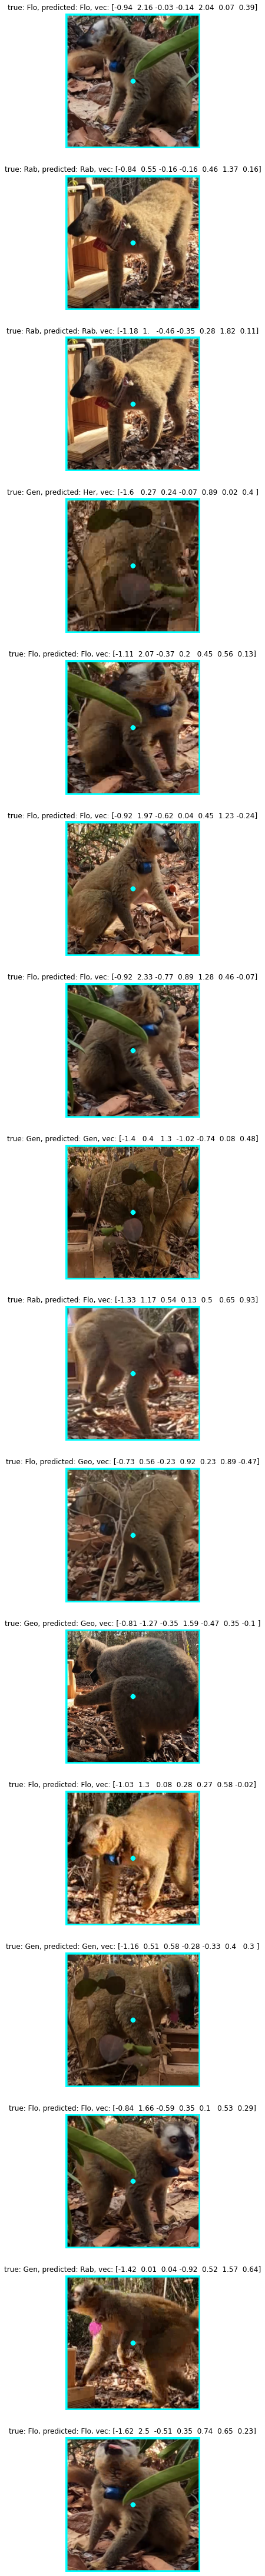

In [657]:
model = model_ft
model.eval()

indivs = ['Cha', 'Flo', 'Gen', 'Geo', 'Her', 'Rab', 'Red']
print(indivs)

n = 16
total = 0
end = False
fig, axs = plt.subplots(n,1, figsize=(15,n*5))

with torch.no_grad():
    for i, inputs in enumerate(dataloaders['val']):
        images = inputs['image'].to(device)
        labels = inputs['label'].to(device)
        
        outputs = model(images.float())
        _, preds = torch.max(outputs, 1)
        
        for j in range(len(preds)):

            #ax = plt.subplot(1, 3, i + 1)
            axs[total].set_title(f'true: {indivs[int(labels[j,0, 6].cpu().numpy())]}, predicted: {indivs[preds[j]]}, vec: {outputs[j].cpu().numpy().round(2)}')
            axs[total].axis('off')
        
            axs[total].imshow(plotBBox(images[j].cpu().numpy().transpose((1, 2, 0)).copy(), labels[j].cpu().numpy()))
            
            total += 1
            
            if total == n:
                end = True
                plt.show()
                break
                
             
        if end:
            break
            